In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from functools import reduce
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn import linear_model
from matplotlib import pyplot as plt

In [2]:
def create_dummy_vars(df, columns):
    for column in columns:
        dummy_vars = columns[column]
        for dummy_var in dummy_vars:
            var_value = dummy_vars[dummy_var]
            df.loc[(df[column].isin(var_value)), dummy_var] = 0
            df.loc[~(df[column].isin(var_value)), dummy_var] = 1
    return df

def calculate_vif(independet_df):
    vif_list = [] 
    x_cols = independet_df.columns
    for x_col in tqdm(x_cols):
        x = independet_df[[x_col]]
        y = independet_df.drop(columns = x_col)
        rsq = smf.ols(formula = 'x~y', data = independet_df).fit().rsquared
        vif = round(1/(1-rsq), 2)
        if vif > 2.5:
            threshold_flag = '1' 
        elif vif <= 2.5:
            threshold_flag = '0'
        var_dict = {'independent_var': x_col, 'vif': vif, 'threshold': threshold_flag}
        vif_list.append(var_dict)
    vif_df = pd.DataFrame(vif_list)
    return vif_df
    
def create_formula(independent_vars):
    dummy_vars = str(str(independent_vars)[2:-2].replace('\', \'', ' + '))
    regression_formula = ("denied ~ " + dummy_vars)
    return regression_formula

def convert_results_to_df(model):
    coef_dict = {'results': dict(model.params), 'col_name': 'coefficient'}
    std_error_dict = {'results': dict(model.bse), 'col_name': 'standard_error'}
    tvalues_dict = {'results': dict(model.tvalues), 'col_name': 'z_value'}
    pvalues_dict = {'results': dict(model.pvalues), 'col_name': 'p_value'}
    oddsratio_dict = {'results': dict(np.exp(model.params)), 'col_name': 'odds_ratio'}
    results_dicts = [coef_dict, std_error_dict, tvalues_dict, pvalues_dict, oddsratio_dict]
    dfs = []    
    for results_dict in results_dicts:
        col_name = results_dict['col_name']
        df = pd.DataFrame.from_dict(results_dict['results'], orient = 'index').reset_index().rename(columns = {'index': 'variable_name', 0: col_name})
        dfs.append(df)
    results_df = reduce(lambda left, right: pd.merge(left, right, on = ['variable_name']), dfs)
    results_df.insert(1, 'pseudo_rsquared', model.prsquared)
    return results_df

def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i,y[i],"{:.0%}".format(y[i]))

# Import Data

In [3]:
data = pd.read_csv("categorized_data.csv", dtype = str)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 659889 entries, 0 to 659888
Data columns (total 82 columns):
 #   Column                                    Non-Null Count   Dtype 
---  ------                                    --------------   ----- 
 0   activity_year                             659889 non-null  object
 1   lei                                       659889 non-null  object
 2   derived_msa_md                            659889 non-null  object
 3   state_code                                656025 non-null  object
 4   county_code                               655570 non-null  object
 5   census_tract                              655288 non-null  object
 6   conforming_loan_limit                     659889 non-null  object
 7   derived_loan_product_type                 659889 non-null  object
 8   derived_dwelling_category                 659889 non-null  object
 9   derived_ethnicity                         659889 non-null  object
 10  derived_race                    

# Create Dummy Variables

In [4]:
cols = [#accept
        {'action_taken': {'denied': ['3']}},
        #white
        {'applicant_race_cat': {'native': ['1'], 'asian': ['2'], 'black': ['3'], 'pac_islander': ['4']}},
        #male
        {'applicant_sex_cat': {'female': ['2']}},
        #Between 34-44
        {'applicant_age_cat': {'less_than25': ['1'], 'between25_34': ['2'], 
                               'between45_54': ['4'], 'between55_64': ['5'], 'between65_74': ['6'],
                               'greater74': ['7']}},
        #30 years
        {'mortgage_term': {'less30yrs_mortgage': ['2'], 'more30yrs_mortgage': ['3']}},
        #TransUnion
        {'applicant_credit_cat': {'equifax': ['1'], 'experian': ['2'], 'other_model': ['4', '6'], 
                                         'more_than_one': ['5'], 'model_na': ['7']}},
        #healthy
        {'dti_cat': {'dti_manageable': ['2'], 'dti_unmanageable': ['3'], 'dti_struggling': ['4']}},
        #20 pct downpayment
        {'downpayment_flag': {'less20pct_downpayment': ['2']}},
        #upper lmi
        {'lmi_def': {'low_lmi': ['1'], 'moderate_lmi': ['2'], 'middle_lmi': ['3'], 'na_lmi': ['5']}},
        #desktop
        {'aus_cat': {'non_desktop': ['2', '3', '4']}}]

In [5]:
continous_vars = ['income_log', 'loan_log']
for i in continous_vars:
    data[i] = pd.to_numeric(data[i])

In [6]:
for i in cols:
    data = create_dummy_vars(data, i)

In [7]:
pd.set_option('display.max_columns', None)
data.head()

,activity_year,lei,derived_msa_md,state_code,county_code,census_tract,conforming_loan_limit,derived_loan_product_type,derived_dwelling_category,derived_ethnicity,derived_race,derived_sex,action_taken,purchaser_type,preapproval,loan_type,loan_purpose,lien_status,reverse_mortgage,open_end_line_of_credit,business_or_commercial_purpose,loan_amount,combined_loan_to_value_ratio,interest_rate,rate_spread,hoepa_status,total_loan_costs,origination_charges,discount_points,loan_term,negative_amortization,interest_only_payment,balloon_payment,other_nonamortizing_features,property_value,construction_method,occupancy_type,manufactured_home_secured_property_type,manufactured_home_land_property_interest,total_units,income,debt_to_income_ratio,applicant_credit_score_type,co_applicant_credit_score_type,applicant_ethnicity_1,co_applicant_ethnicity_1,applicant_ethnicity_observed,co_applicant_ethnicity_observed,applicant_race_1,co_applicant_race_1,applicant_race_observed,co_applicant_race_observed,applicant_sex,co_applicant_sex,applicant_sex_observed,co_applicant_sex_observed,applicant_age,co_applicant_age,applicant_age_above_62,co_applicant_age_above_62,submission_of_application,initially_payable_to_institution,aus_1,denial_reason_1,tract_population,tract_minority_population_percent,ffiec_msa_md_median_family_income,tract_to_msa_income_percentage,tract_owner_occupied_units,tract_one_to_four_family_homes,tract_median_age_of_housing_units,dti_cat,downpayment_flag,applicant_age_cat,applicant_sex_cat,aus_cat,mortgage_term,lmi_def,applicant_race_cat,applicant_credit_cat,income_log,loan_log,denied,native,asian,black,pac_islander,female,less_than25,between25_34,between45_54,between55_64,between65_74,greater74,less30yrs_mortgage,more30yrs_mortgage,equifax,experian,other_model,more_than_one,model_na,dti_manageable,dti_unmanageable,dti_struggling,less20pct_downpayment,low_lmi,moderate_lmi,middle_lmi,na_lmi,non_desktop
0,2020,549300EOHSB7M6IFW844,19660,FL,12127.0,12127091029.0,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built,Not Hispanic or Latino,White,Female,1,0,2,1,1,1,2,2,2,75000,79.0,3.875,0.983,2,4845.38,2997.5,1507.5,360,2,2,2,2,95000,1,1,3,5,1,34.0,48,1,10,2.0,5.0,2,4,5.0,8.0,2,4,2,5,2,4,55-64,9999,Yes,NaN,1,1,2,10,4776,24.58,65000,90.0,1617,2140,26,3,1,5,2,2,1,3,5,1,3.526361,11.225243,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0
1,2020,549300EOHSB7M6IFW844,36740,FL,12117.0,12117020902.0,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built,Hispanic or Latino,White,Female,1,0,2,1,1,1,2,2,2,165000,95.0,3.375,0.637,2,5176.23,2498.33,1008.33,360,2,2,2,2,175000,1,1,3,5,1,25.0,46,1,10,1.0,5.0,2,4,5.0,8.0,2,4,2,5,2,4,<25,9999,No,NaN,1,1,2,10,1940,45.05,68100,75.0,564,1089,45,3,2,1,2,2,1,2,5,1,3.218876,12.013701,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0
2,2020,549300EOHSB7M6IFW844,23540,FL,12001.0,12001001803.0,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built,Not Hispanic or Latino,White,Female,1,0,2,1,1,1,2,2,2,195000,80.0,3.5,0.32,2,10192.95,3295.2,1705.2,360,2,2,2,2,245000,1,1,3,5,1,46.0,42,1,10,2.0,5.0,2,4,5.0,8.0,2,4,2,5,2,4,55-64,9999,No,NaN,1,1,2,10,6207,40.99,65600,116.0,2020,2805,32,2,1,5,2,2,1,3,5,1,3.828641,12.180755,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0
3,2020,549300EOHSB7M6IFW844,19660,FL,12035.0,12035060107.0,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built,Not Hispanic or Latino,White,Female,1,0,2,1,1,1,2,2,2,135000,80.0,3.5,0.429,2,4997.53,3109.28,1619.28,360,2,2,2,2,175000,1,1,3,5,1,29.0,36,2,10,2.0,5.0,2,4,5.0,8.0,2,4,2,5,2,4,55-64,9999,No,NaN,1,1,1,10,4555,32.25,65000,94.0,1461,2211,27,2,1,5,2,1,1,3,5,2,3.367296,11.813030,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0
4,2020,549300EOHSB7M6IFW844,15980,FL,12071.0,1207

In [8]:
variables = ['native', 'asian', 'black', 'pac_islander',
             'female',
             'less_than25', 'between25_34', 'between45_54', 'between55_64', 'between65_74', 'greater74', 
             'income_log', 'loan_log',
             'less30yrs_mortgage', 'more30yrs_mortgage',
             'equifax', 'experian', 'other_model', 'more_than_one', 'model_na',
             'dti_manageable', 'dti_unmanageable', 'dti_struggling',
             'less20pct_downpayment',
             'low_lmi','moderate_lmi', 'middle_lmi', 'na_lmi',
             'non_desktop']

print(len(variables))

29


In [9]:
data.to_csv('regression_data.csv', index = False)

# Explore fairness in data

In [10]:
mean_pass_1 = data.loc[data["applicant_race_cat"] == '1', 'denied'].mean()
mean_pass_2 = data.loc[data["applicant_race_cat"] == '2', 'denied'].mean()
mean_pass_3 = data.loc[data["applicant_race_cat"] == '3', 'denied'].mean()
mean_pass_4 = data.loc[data["applicant_race_cat"] == '4', 'denied'].mean()
mean_pass_5 = data.loc[data["applicant_race_cat"] == '5', 'denied'].mean()
print(mean_pass_1, mean_pass_2, mean_pass_3, mean_pass_4, mean_pass_5)

0.8646362098138748 0.9017898199568463 0.8285401050430881 0.8381555153707052 0.9350023797510029


In [11]:
mean_pass_1 = data.loc[data["applicant_sex_cat"] == '1', 'denied'].mean()
mean_pass_2 = data.loc[data["applicant_sex_cat"] == '2', 'denied'].mean()
print(mean_pass_1, mean_pass_2)

0.9273480840033328 0.9214776632302405


# Run Regression

In [12]:
y = data['denied']
x = data[variables]

In [13]:
logit_model = sm.Logit(y, sm.add_constant(x)).fit()
logit_model.summary()

/Users/haozhengwang/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Optimization terminated successfully.
         Current function value: 0.199934
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 denied   No. Observations:               659889
Model:                          Logit   Df Residuals:                   659859
Method:                           MLE   Df Model:                           29
Date:                Sun, 01 May 2022   Pseudo R-squ.:                  0.2479
Time:                        23:26:11   Log-Likelihood:            -1.3193e+05
converged:                       True   LL-Null:                   -1.7541e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                   -12.6983      0.216    -58.775      0.000     -13.122     -12.275
native                    0.6134      0.056     10.988      0.000       0.504       0.723
asian                     0.4927      0.019     26.358      0.000       0.456       0.529
black                     0.7102      0.018     38.575      0.000       0.674       0.746
pac_islander              0.8256      0.101      8.144      0.000       0.627       1.024
female                   -0.0769      0.012     -6.608      0.000      -0.100      -0.054
less_than25              -0.1044      0.026     -4.040      0.000      -0.155      -0.054
between25_34             -0.2857      0.015    -19.242      0.000      -0.315      -0.257
between45_54              0.1090      0.017      6.545      0.000       0.076       0.142
between55_64             -0.0169      0.019     -0.870      0.384      -0.055       0.021
between65_74             -0.2865      0.026    -10.815      0.000      -0.338      -0.235
greater74                -0.1964      0.046     -4.286      0.000      -0.286      -0.107
income_log               -0.0734      0.012     -5.988      0.000      -0.097      -0.049
loan_log                  0.3433      0.013     27.085      0.000       0.318       0.368
less30yrs_mortgage        0.0670      0.022      3.007      0.003       0.023       0.111
more30yrs_mortgage        0.8712      0.038     23.188      0.000       0.798       0.945
equifax                  -0.0056      0.014     -0.407      0.684      -0.032       0.021
experian                  0.0619      0.015      4.224      0.000       0.033       0.091
other_model               0.5094      0.040     12.624      0.000       0.430       0.589
more_than_one            -0.6316      0.051    -12.421      0.000      -0.731      -0.532
model_na                  0.3876      0.024     16.241      0.000       0.341       0.434
dti_manageable           -0.0062      0.014     -0.432      0.666      -0.035       0.022
dti_unmanageable          0.3697      0.015     24.276      0.000       0.340       0.399
dti_struggling            4.3652      0.022    197.536      0.000       4.322       4.409
less20pct_downpayment     0.3857      0.012     31.198      0.000       0.361       0.410
low_lmi                   0.5184      0.034     15.243      0.000       0.452       0.585
moderate_lmi              0.3434      0.018     19.403      0.000       0.309       0.378
middle_lmi                0.1133      0.013      8.698      0.000       0.088       0.139
na_lmi                    3.5728      0.037     96.283      0.000       3.500       3.646
non_desktop              -0.6080      0.018    -34.401      0.000      -0.643      -0.573
=========================================================================================
"""

# Findings:

In [14]:
national_findings_df = convert_results_to_df(logit_model)
races = ['native','asian','black','pac_islander']
national_findings_df[(national_findings_df['variable_name'].isin(races))]

,variable_name,pseudo_rsquared,coefficient,standard_error,z_value,p_value,odds_ratio
1,native,0.247855,0.613430,0.055825,10.988453,4.343040e-28,1.846755
2,asian,0.247855,0.492682,0.018692,26.357563,4.203764e-153,1.636700
3,black,0.247855,0.710179,0.018410,38.575167,0.000000e+00,2.034356
4,pac_islander,0.247855,0.825606,0.101379,8.143782,3.831186e-16,2.283265


In [15]:
sex = ['female']
national_findings_df[(national_findings_df['variable_name'].isin(sex))]

,variable_name,pseudo_rsquared,coefficient,standard_error,z_value,p_value,odds_ratio
5,female,0.247855,-0.07692,0.011641,-6.607661,3.904392e-11,0.925964


In [16]:
dti = ['dti_manageable', 'dti_unmanageable', 'dti_struggling']
national_findings_df[(national_findings_df['variable_name'].isin(dti))]

,variable_name,pseudo_rsquared,coefficient,standard_error,z_value,p_value,odds_ratio
21,dti_manageable,0.247855,-0.006246,0.014457,-0.432035,6.657157e-01,0.993774
22,dti_unmanageable,0.247855,0.369651,0.015227,24.276430,3.478344e-130,1.447229
23,dti_struggling,0.247855,4.365199,0.022098,197.536418,0.000000e+00,78.665037


In [17]:
race_1 = ['1', '2', '3', '4', '5']
race_2 = ['native', 'asian', 'black', 'pac_islander', 'white']

In [18]:
dti_healthy_df = data[data['dti_cat'] == '1']
dti_manageable_df = data[data['dti_cat'] == '2']
dti_unmanageable_df = data[data['dti_cat'] == '3']
dti_struggling_df = data[data['dti_cat'] == '4']

/var/folders/1k/b0c_1p1s4yz36hhp462pxzjr0000gn/T/ipykernel_27709/960832056.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dti_healthy_ratio.append(len(dti_healthy_df[dti_healthy_df['applicant_race_cat'] == i][dti_healthy_df['denied'] == 1])/len(dti_healthy_df[dti_healthy_df['applicant_race_cat'] == i]))


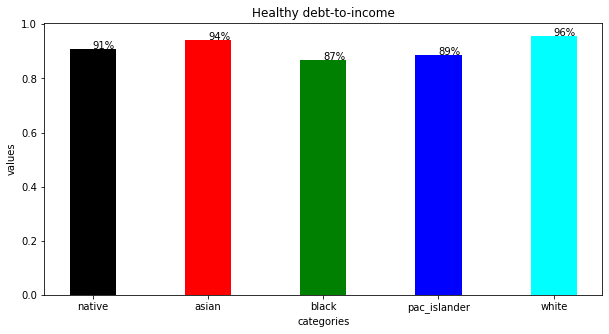

In [19]:
dti_healthy_ratio = []
for i in race_1:
    dti_healthy_ratio.append(len(dti_healthy_df[dti_healthy_df['applicant_race_cat'] == i][dti_healthy_df['denied'] == 1])/len(dti_healthy_df[dti_healthy_df['applicant_race_cat'] == i]))
fig = plt.figure(figsize = (10, 5))
plt.bar(race_2, dti_healthy_ratio, color=['black', 'red', 'green', 'blue', 'cyan'], width = 0.4)
addlabels(race_2, dti_healthy_ratio)
plt.title('Healthy debt-to-income')
plt.xlabel('categories')
plt.ylabel('values')
plt.show()

/var/folders/1k/b0c_1p1s4yz36hhp462pxzjr0000gn/T/ipykernel_27709/99846412.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dti_manageable_ratio.append(len(dti_manageable_df[dti_manageable_df['applicant_race_cat'] == i][dti_manageable_df['denied'] == 1])/len(dti_manageable_df[dti_manageable_df['applicant_race_cat'] == i]))


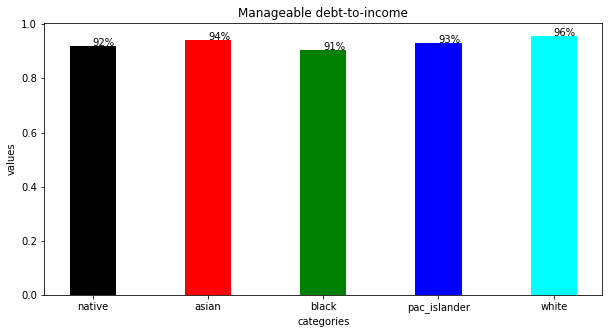

In [20]:
dti_manageable_ratio = []
for i in race_1:
    dti_manageable_ratio.append(len(dti_manageable_df[dti_manageable_df['applicant_race_cat'] == i][dti_manageable_df['denied'] == 1])/len(dti_manageable_df[dti_manageable_df['applicant_race_cat'] == i]))
fig = plt.figure(figsize = (10, 5))
plt.bar(race_2, dti_manageable_ratio, color=['black', 'red', 'green', 'blue', 'cyan'], width = 0.4)
addlabels(race_2, dti_manageable_ratio)
plt.title('Manageable debt-to-income')
plt.xlabel('categories')
plt.ylabel('values')
plt.show()

/var/folders/1k/b0c_1p1s4yz36hhp462pxzjr0000gn/T/ipykernel_27709/872008120.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dti_unmanageable_ratio.append(len(dti_unmanageable_df[dti_unmanageable_df['applicant_race_cat'] == i][dti_unmanageable_df['denied'] == 1])/len(dti_unmanageable_df[dti_unmanageable_df['applicant_race_cat'] == i]))


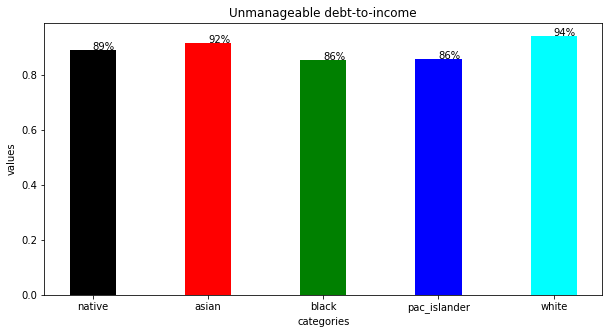

In [21]:
dti_unmanageable_ratio = []
for i in race_1:
    dti_unmanageable_ratio.append(len(dti_unmanageable_df[dti_unmanageable_df['applicant_race_cat'] == i][dti_unmanageable_df['denied'] == 1])/len(dti_unmanageable_df[dti_unmanageable_df['applicant_race_cat'] == i]))
fig = plt.figure(figsize = (10, 5))
plt.bar(race_2, dti_unmanageable_ratio, color=['black', 'red', 'green', 'blue', 'cyan'], width = 0.4)
addlabels(race_2, dti_unmanageable_ratio)
plt.title('Unmanageable debt-to-income')
plt.xlabel('categories')
plt.ylabel('values')
plt.show()

/var/folders/1k/b0c_1p1s4yz36hhp462pxzjr0000gn/T/ipykernel_27709/522829354.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dti_struggling_ratio.append(len(dti_struggling_df[dti_struggling_df['applicant_race_cat'] == i][dti_struggling_df['denied'] == 1])/len(dti_struggling_df[dti_struggling_df['applicant_race_cat'] == i]))


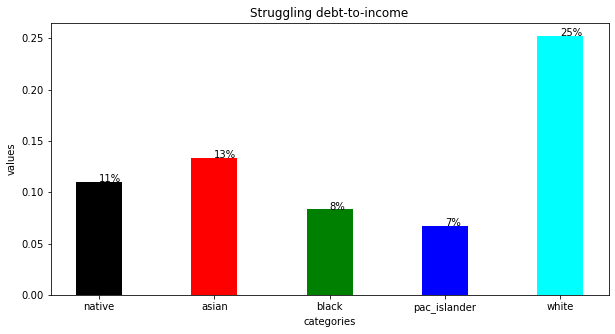

In [22]:
dti_struggling_ratio = []
for i in race_1:
    dti_struggling_ratio.append(len(dti_struggling_df[dti_struggling_df['applicant_race_cat'] == i][dti_struggling_df['denied'] == 1])/len(dti_struggling_df[dti_struggling_df['applicant_race_cat'] == i]))
fig = plt.figure(figsize = (10, 5))
plt.bar(race_2, dti_struggling_ratio, color=['black', 'red', 'green', 'blue', 'cyan'], width = 0.4)
addlabels(race_2, dti_struggling_ratio)
plt.title('Struggling debt-to-income')
plt.xlabel('categories')
plt.ylabel('values')
plt.show()

In [23]:
gender_1 = ['1','2']
gender_2 = ['male', 'female']
native_df = data[data['applicant_race_cat'] == '1']
asian_df = data[data['applicant_race_cat'] == '2']
black_df = data[data['applicant_race_cat'] == '3']
pac_df = data[data['applicant_race_cat'] == '4']
white_df = data[data['applicant_race_cat'] == '5']

/var/folders/1k/b0c_1p1s4yz36hhp462pxzjr0000gn/T/ipykernel_27709/2309954669.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  native_ratio.append(len(native_df[native_df['applicant_sex_cat'] == i][native_df['denied'] == 1])/len(native_df[native_df['applicant_sex_cat'] == i]))


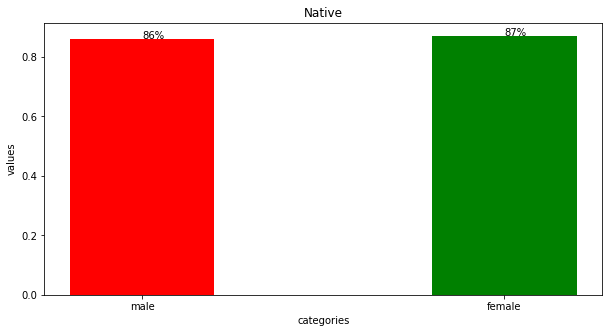

In [24]:
native_ratio = []
for i in gender_1:
    native_ratio.append(len(native_df[native_df['applicant_sex_cat'] == i][native_df['denied'] == 1])/len(native_df[native_df['applicant_sex_cat'] == i]))
fig = plt.figure(figsize = (10, 5))
plt.bar(gender_2, native_ratio, color=['red', 'green'], width = 0.4)
addlabels(gender_2,native_ratio)
plt.title('Native')
plt.xlabel('categories')
plt.ylabel('values')
plt.show()

/var/folders/1k/b0c_1p1s4yz36hhp462pxzjr0000gn/T/ipykernel_27709/2485026999.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  asian_ratio.append(len(asian_df[asian_df['applicant_sex_cat'] == i][asian_df['denied'] == 1])/len(asian_df[asian_df['applicant_sex_cat'] == i]))


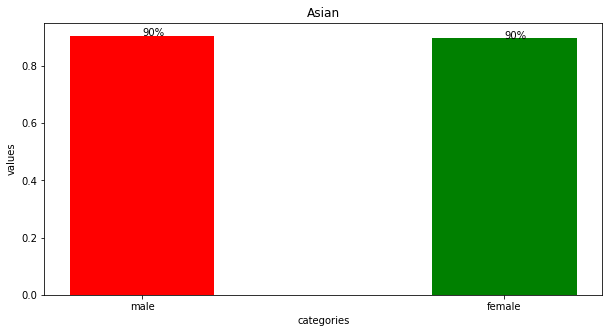

In [25]:
asian_ratio = []
for i in gender_1:
    asian_ratio.append(len(asian_df[asian_df['applicant_sex_cat'] == i][asian_df['denied'] == 1])/len(asian_df[asian_df['applicant_sex_cat'] == i]))
fig = plt.figure(figsize = (10, 5))
plt.bar(gender_2, asian_ratio, color=['red', 'green'], width = 0.4)
addlabels(gender_2,asian_ratio)
plt.title('Asian')
plt.xlabel('categories')
plt.ylabel('values')
plt.show()

/var/folders/1k/b0c_1p1s4yz36hhp462pxzjr0000gn/T/ipykernel_27709/3909061862.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  black_ratio.append(len(black_df[black_df['applicant_sex_cat'] == i][black_df['denied'] == 1])/len(black_df[black_df['applicant_sex_cat'] == i]))


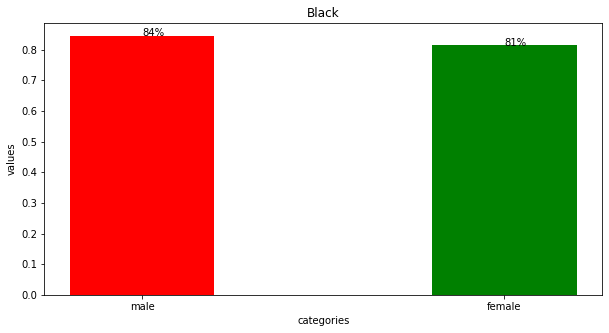

In [26]:
black_ratio = []
for i in gender_1:
    black_ratio.append(len(black_df[black_df['applicant_sex_cat'] == i][black_df['denied'] == 1])/len(black_df[black_df['applicant_sex_cat'] == i]))
fig = plt.figure(figsize = (10, 5))
plt.bar(gender_2, black_ratio, color=['red', 'green'], width = 0.4)
addlabels(gender_2,black_ratio)
plt.title('Black')
plt.xlabel('categories')
plt.ylabel('values')
plt.show()

/var/folders/1k/b0c_1p1s4yz36hhp462pxzjr0000gn/T/ipykernel_27709/309208903.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  pac_ratio.append(len(pac_df[pac_df['applicant_sex_cat'] == i][pac_df['denied'] == 1])/len(pac_df[pac_df['applicant_sex_cat'] == i]))


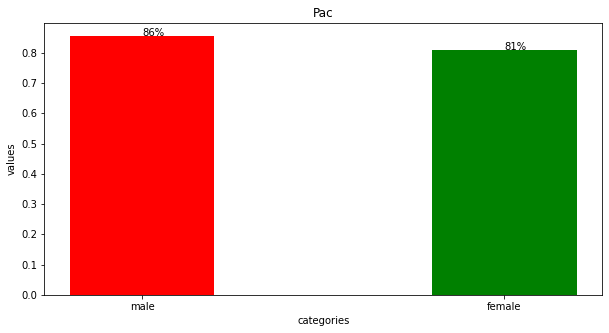

In [27]:
pac_ratio = []
for i in gender_1:
    pac_ratio.append(len(pac_df[pac_df['applicant_sex_cat'] == i][pac_df['denied'] == 1])/len(pac_df[pac_df['applicant_sex_cat'] == i]))
fig = plt.figure(figsize = (10, 5))
plt.bar(gender_2, pac_ratio, color=['red', 'green'], width = 0.4)
addlabels(gender_2,pac_ratio)
plt.title('Pac')
plt.xlabel('categories')
plt.ylabel('values')
plt.show()

/var/folders/1k/b0c_1p1s4yz36hhp462pxzjr0000gn/T/ipykernel_27709/4240452617.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  white_ratio.append(len(white_df[white_df['applicant_sex_cat'] == i][white_df['denied'] == 1])/len(white_df[white_df['applicant_sex_cat'] == i]))


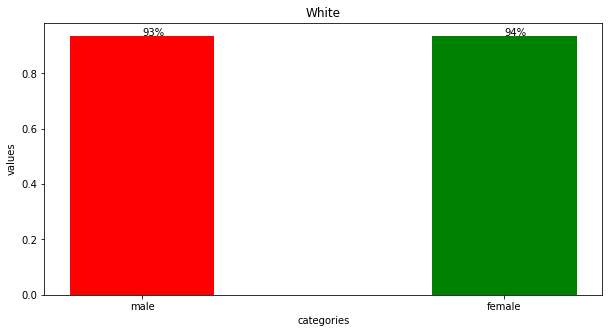

In [28]:
white_ratio = []
for i in gender_1:
    white_ratio.append(len(white_df[white_df['applicant_sex_cat'] == i][white_df['denied'] == 1])/len(white_df[white_df['applicant_sex_cat'] == i]))
fig = plt.figure(figsize = (10, 5))
plt.bar(gender_2, white_ratio, color=['red', 'green'], width = 0.4)
addlabels(gender_2,white_ratio)
plt.title('White')
plt.xlabel('categories')
plt.ylabel('values')
plt.show()